Approximation Error Comparison

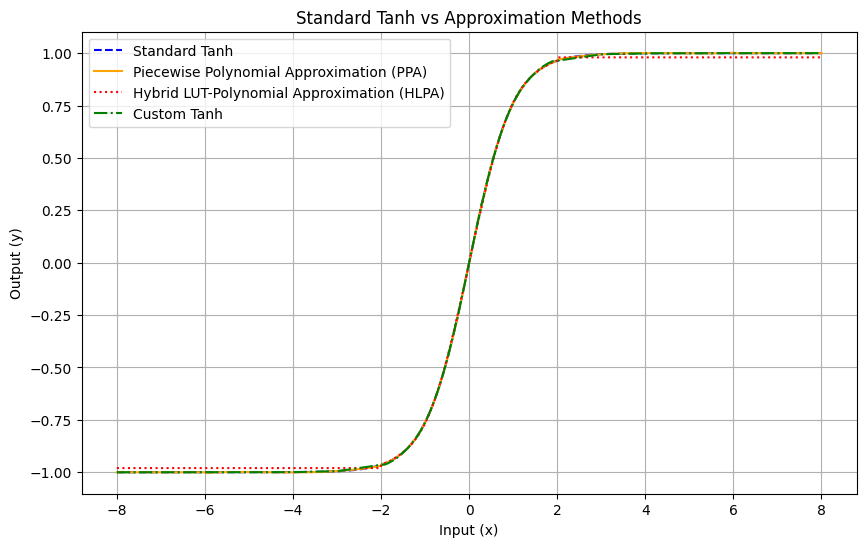

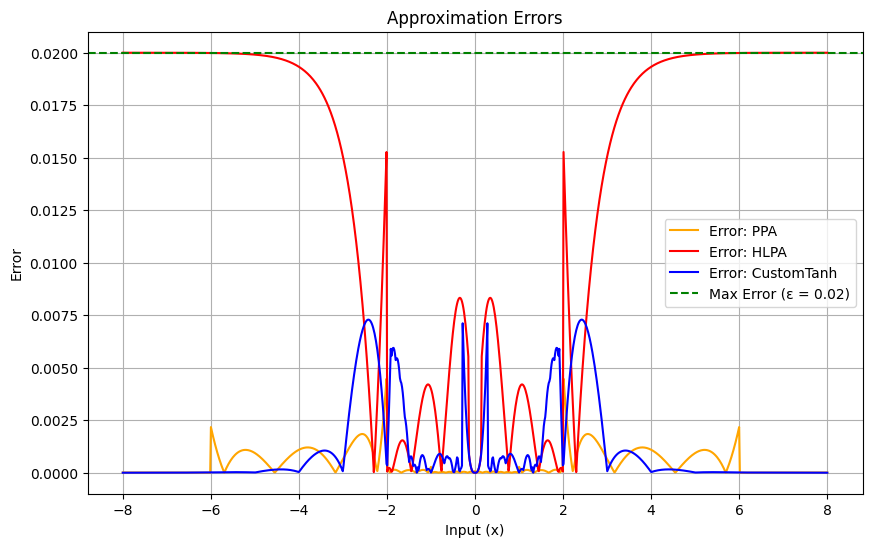

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Piecewise Polynomial Approximation (PPA)
class PPA(tf.keras.layers.Layer):
    def __init__(self, epsilon=0.02):
        super().__init__()
        self.epsilon = epsilon

        # segmentation brkpts
        self.brkpts = np.array([-6.0, -2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0, 6.0])
        self.values = np.tanh(self.brkpts)
        self.coefficients = self.opt_coeff()

    def opt_coeff(self):
        coefficients = []
        for i in range(len(self.brkpts) - 1):
            x_start, x_end = self.brkpts[i], self.brkpts[i + 1]
            x_range = np.linspace(x_start, x_end, 200)
            y_range = np.tanh(x_range)
            poly_coeff = np.polyfit(x_range, y_range, 3)
            coefficients.append(poly_coeff)
        return coefficients

    def call(self, inputs):
        inputs = tf.clip_by_value(inputs, -6.0, 6.0)
        outputs = tf.zeros_like(inputs)

        # polynomial approximation for segments
        for i in range(len(self.brkpts) - 1):
            x_start, x_end = self.brkpts[i], self.brkpts[i + 1]
            mask = tf.logical_and(inputs >= x_start, inputs < x_end)
            coeffs = self.coefficients[i]
            poly_values = coeffs[0] * inputs**3 + coeffs[1] * inputs**2 + coeffs[2] * inputs + coeffs[3]
            outputs = tf.where(mask, poly_values, outputs)

        # saturation regions
        outputs = tf.where(inputs >= self.brkpts[-1], self.values[-1], outputs)
        outputs = tf.where(inputs <= self.brkpts[0], self.values[0], outputs)

        return outputs

# Hybrid LUT-Polynomial Approximation with Fixed saturation Region (HLPA)
class HLPA(tf.keras.layers.Layer):
    def __init__(self, epsilon=0.02):
        super().__init__()
        self.epsilon = epsilon

        # pass, processing, and saturation region boundaries
        self.pass_region_end = tf.constant(0.15, dtype=tf.float32)
        self.sat_region_start = tf.constant(2.0, dtype=tf.float32)

        # coefficients for [-2, 2]
        self.poly_coeffs = np.polyfit(
            np.linspace(-2.0, 2.0, 500), np.tanh(np.linspace(-2.0, 2.0, 500)), 5
        )

    def call(self, inputs):
        x_abs = tf.abs(inputs)
        tanh_approx = tf.where(
            x_abs <= self.pass_region_end,
            inputs,  # Pass region
            tf.where(
                (inputs >= -2.0) & (inputs <= 2.0),
                self.blended_processing(inputs),  # Processing region [-2, 2]
                tf.where(
                    x_abs <= self.sat_region_start,
                    self.poly_approx(inputs),
                    tf.sign(inputs) * (1 - self.epsilon)
                )
            )
        )
        return tanh_approx

    #polynomial using the coefficent is returned
    def poly_approx(self, x):
        return (
            self.poly_coeffs[0] * x**5 +
            self.poly_coeffs[1] * x**4 +
            self.poly_coeffs[2] * x**3 +
            self.poly_coeffs[3] * x**2 +
            self.poly_coeffs[4] * x +
            self.poly_coeffs[5]
        )

    def blended_processing(self, x):
        poly_result = self.poly_approx(x)
        weights = tf.clip_by_value(1 - (tf.abs(x) / 2.0), 0, 1)
        return weights * poly_result + (1 - weights) * tf.tanh(x)

class CustomTanh(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomTanh, self).__init__()
        self.y_values = tf.constant([0.0, 0.956, 0.964, 0.995, 0.9993, 0.9999, 0.99998, 0.999998, 0.999999], dtype=tf.float32)
        self.array = tf.constant([0.0, 0.0, 0.0651, 0.0643, 0.0628, 0.0606, 0.0582, 0.0557, 0.0530, 0.0503,
                                  0.0476, 0.0449, 0.0423, 0.0397, 0.0373, 0.0350, 0.0329, 0.0309, 0.0290, 0.0272, 0.256], dtype=tf.float32)

#       decimal_pos = num_str.find('.')
#       first_digit = num_str[decimal_pos + 1]
#       return int(first_digit)

    def call(self, x):
        abs_x = tf.abs(x)

        # central linear segment
        central_mask = tf.logical_and(x >= -0.29, x <= 0.29)
        result = tf.where(central_mask, x, tf.constant(0.0, dtype=tf.float32))

        # high absolute value segments
        high_mask = abs_x > 1.9
        abs_1_x = tf.cast(tf.math.ceil(abs_x),tf.float32)
        high_index = tf.cast(abs_1_x, tf.int32)
        high_value = tf.gather(self.y_values, high_index) - ((abs_1_x - abs_x) * (tf.gather(self.y_values, high_index) - tf.gather(self.y_values, high_index-1)))
        high_result = tf.where(x < -1.9, -high_value, high_value)
        result = tf.where(high_mask, high_result, result)

        # middle segments
        abs_x = tf.abs(x)
        middle_mask = tf.logical_and(abs_x > 0.29, abs_x <= 1.9)
        array_index = tf.minimum(tf.cast(tf.floor(abs_x * 10), tf.int32), tf.constant(19, dtype=tf.int32))
        divisor_reciprocal = tf.gather(self.array, array_index) - ((abs_x*10 - tf.floor(abs_x*10)) * (tf.gather(self.array, array_index) - tf.gather(self.array, array_index+1)))
        x2 = tf.round(x * x * 10000) / 10000
        middle_result = x * (tf.constant(15.0, dtype=tf.float32) + x2) * divisor_reciprocal
        result = tf.where(middle_mask, middle_result, result)

        return result




# define input range and standard tanh
x = np.linspace(-8, 8, 1000, dtype=np.float32)
standard_tanh = np.tanh(x)

# methods instantiation
ppa_layer = PPA()
hlpa_layer = HLPA()
custom_layer = CustomTanh()
# compute outputs
ppa_output = ppa_layer(tf.constant(x, dtype=tf.float32)).numpy()
hlpa_output = hlpa_layer(tf.constant(x, dtype=tf.float32)).numpy()
custom_output = custom_layer(tf.constant(x, dtype=tf.float32)).numpy()

# plot standard tanh vs other methods
plt.figure(figsize=(10, 6))
plt.plot(x, standard_tanh, label="Standard Tanh", linestyle="--", color="blue")
plt.plot(x, ppa_output, label="Piecewise Polynomial Approximation (PPA)", linestyle="-", color="orange")
plt.plot(x, hlpa_output, label="Hybrid LUT-Polynomial Approximation (HLPA)", linestyle=":", color="red")
plt.plot(x, custom_output, label="Custom Tanh", linestyle="dashdot", color="green")

plt.title("Standard Tanh vs Approximation Methods")
plt.xlabel("Input (x)")
plt.ylabel("Output (y)")
plt.legend()
plt.grid()
plt.show()

# compute and plot approximation errors
ppa_error = np.abs(standard_tanh - ppa_output)
hlpa_error = np.abs(standard_tanh - hlpa_output)
custom_error = np.abs(standard_tanh - custom_output)

plt.figure(figsize=(10, 6))
plt.plot(x, ppa_error, label="Error: PPA", color="orange")
plt.plot(x, hlpa_error, label="Error: HLPA", color="red")
plt.plot(x, custom_error, label="Error: CustomTanh", color="blue")

plt.axhline(y=0.02, color="green", linestyle="--", label="Max Error (ε = 0.02)")
plt.title("Approximation Errors")
plt.xlabel("Input (x)")
plt.ylabel("Error")
plt.legend()
plt.grid()
plt.show()


Integrating the tanh function to LSTM

In [ ]:
!pip install tensorflow tensorflow_datasets matplotlib numpy pydub
!apt-get install -y ffmpeg

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds

class PPA(tf.keras.layers.Layer):
    def __init__(self, epsilon=0.02):
        super().__init__()
        self.epsilon = epsilon
        self.brkpts = np.array([-6.0, -2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0, 6.0], dtype=np.float32)
        self.values = np.tanh(self.brkpts).astype(np.float32)
        self.coefficients = self.opt_coeff()

    def opt_coeff(self):
        coefficients = []
        for i in range(len(self.brkpts) - 1):
            x_start, x_end = self.brkpts[i], self.brkpts[i + 1]
            x_range = np.linspace(x_start, x_end, 200, dtype=np.float32)
            y_range = np.tanh(x_range).astype(np.float32)
            poly_coeff = np.polyfit(x_range, y_range, 3)
            coefficients.append(poly_coeff.astype(np.float32))
        return coefficients


    def call(self, inputs):
        inputs = tf.clip_by_value(inputs, -6.0, 6.0)
        outputs = tf.zeros_like(inputs)
        for i in range(len(self.brkpts) - 1):
            x_start, x_end = self.brkpts[i], self.brkpts[i + 1]
            mask = tf.logical_and(inputs >=x_start, inputs < x_end)
            coeffs = self.coefficients[i]
            poly_values = coeffs[0] * inputs**3 + coeffs[1] * inputs**2 +coeffs[2] * inputs + coeffs[3]
            outputs = tf.where(mask, poly_values, outputs)
        outputs = tf.where(inputs >= self.brkpts[-1], self.values[-1], outputs)
        outputs = tf.where(inputs <= self.brkpts[0], self.values[0], outputs)
        return outputs

class HLPA(tf.keras.layers.Layer):
    def __init__(self, epsilon=0.02):
        super().__init__()
        self.epsilon = epsilon
        self.pass_region_end = tf.constant(0.15, dtype=tf.float32)
        self.sat_region_start = tf.constant(2.0, dtype=tf.float32)
        self.poly_coeffs = np.polyfit(
            np.linspace(-2.0, 2.0, 500, dtype=np.float32),
            np.tanh(np.linspace(-2.0, 2.0, 500).astype(np.float32)),
            5
        ).astype(np.float32)


    def call(self, inputs):
        x_abs = tf.abs(inputs)
        tanh_approx = tf.where(
            x_abs <= self.pass_region_end,
            inputs,
            tf.where(
                (inputs >= -2.0) & (inputs <= 2.0),
                self.blended_processing(inputs),
                tf.where(
                    x_abs <= self.sat_region_start,
                    self.poly_approx(inputs),
                    tf.sign(inputs) * (1 - self.epsilon)
                )
            )
        )
        return tanh_approx


    def poly_approx(self, x):
        return (
            self.poly_coeffs[0] * x**5 + self.poly_coeffs[1] * x**4 + self.poly_coeffs[2] * x**3 + self.poly_coeffs[3] * x**2 + self.poly_coeffs[4] * x +
            self.poly_coeffs[5]
        )

    def blended_processing(self, x):
        poly_result = self.poly_approx(x)
        weights = tf.clip_by_value(1 - (tf.abs(x) / 2.0), 0, 1)
        return weights * poly_result + (1 - weights) * tf.tanh(x)

class CustomTanh(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomTanh, self).__init__()
        self.y_values = tf.constant([0.0, 0.956, 0.964, 0.995, 0.9993, 0.9999, 0.99998, 0.999998, 0.999999],  dtype=tf.float32)
        self.array = tf.constant([0.0, 0.0, 0.0651, 0.0643, 0.0628, 0.0606, 0.0582, 0.0557, 0.0530, 0.0503,
                                  0.0476, 0.0449, 0.0423, 0.0397, 0.0373, 0.0350, 0.0329, 0.0309, 0.0290, 0.0272, 0.256], dtype=tf.float32)

    def call(self, x):
        abs_x = tf.abs(x)

        # central linear segment
        central_mask = tf.logical_and(x >= -0.29, x <= 0.29)
        result = tf.where(central_mask, x, tf.constant(0.0, dtype=tf.float32))


        # high absolute value segments
        high_mask = abs_x > 1.9
        abs_1_x = tf.cast(tf.math.ceil(abs_x),tf.float32)
        high_index = tf.cast(abs_1_x, tf.int32)
        high_value = tf.gather(self.y_values, high_index) - ((abs_1_x - abs_x) * (tf.gather(self.y_values, high_index) - tf.gather(self.y_values, high_index-1)))
        high_result = tf.where(x < -1.9, -high_value,high_value)
        result = tf.where(high_mask, high_result, result)

        # midle segments
        abs_x = tf.abs(x)
        middle_mask = tf.logical_and(abs_x > 0.29, abs_x <= 1.9)
        array_index = tf.minimum(tf.cast(tf.floor(abs_x * 10), tf.int32), tf.constant(19, dtype=tf.int32))
        divisor_reciprocal = tf.gather(self.array, array_index) - ((abs_x*10 - tf.floor(abs_x*10)) * (tf.gather(self.array, array_index) - tf.gather(self.array, array_index+1)))


        x2 = tf.round(x * x * 10000) / 10000
        middle_result = x * (tf.constant(15.0, dtype=tf.float32) + x2) * divisor_reciprocal
        result = tf.where(middle_mask, middle_result, result)
        return result

# audio preprocessing
def preprocess_audio(data, label):
    data = tf.cast(data, tf.float32) / 32768.0
    spectrogram = tf.signal.stft(data, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=64, num_spectrogram_bins=spectrogram.shape[-1], sample_rate=16000
    )
    mel_spectrogram = tf.tensordot(spectrogram, mel_weight_matrix, axes=1)
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)
    mel_spectrogram = tf.image.resize(mel_spectrogram, [64, 64])
    mel_spectrogram = tf.squeeze(mel_spectrogram, axis=-1)
    return mel_spectrogram, label

# dataset laoding
dataset_name = "speech_commands"
(train_dataset, test_dataset), dataset_info = tfds.load(
    dataset_name, split=["train", "test"], as_supervised=True, with_info=True
)
batch_size = 32
train_dataset = train_dataset.map(preprocess_audio).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_audio).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#LSTM model defintion
def build_lstm_model(input_shape, activation_function):
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),
        LSTM(64, activation=activation_function, return_sequences=False, dropout=0.2),
        Dense(64, activation="relu"),
        Dense(12, activation="softmax")
    ])
    return model

input_shape = (64, 64)
results = {}
mse_results = {}

activations = {
    "Standard Tanh": "tanh",
    "PPA": PPA(),
    "HLPA": HLPA(),
    "CustomTanh": CustomTanh()
}

#error =[][]
approximation_errors = []
validation_accuracies = []


# Train and evaluate
# iterating over all three methods
for name, activation in activations.items():
    print(f"Training with {name}...")
    model = build_lstm_model(input_shape, activation)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=50)
    results[name] = history.history

    lstm = LSTM(128, activation=activation, return_sequences=True, return_state=True) #model instanciation
    inputs = tf.random.normal([32, 64, 128])
    outputs, hidden_state, cell_state = lstm(inputs)
    #mse_hidden = tf.reduce_mean(tf.square(hidden_state - tf.tanh(hidden_state)))
    #mse_cell = tf.reduce_mean(tf.square(cell_state - tf.tanh(cell_state)))
    #mse = np.mean([mse_hidden.numpy(), mse_cell.numpy()])
    #mse_results[name] = mse

    #pproximation_errors.append(mse)
    validation_accuracies.append(np.max(history.history['val_accuracy']))

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Training with PPA...
Epoch 1/50
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.6349 - loss: 1.3878 - val_accuracy: 0.4260 - val_loss: 1.5685
Epoch 2/50
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.7482 - loss: 0.7868 - val_accuracy: 0.5601 - val_loss: 1.2039
Epoch 3/50
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.7933 - loss: 0.6323 - val_accuracy: 0.6270 - val_loss: 1.0648
Epoch 4/50
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.8222 - loss: 0.5539 - val_accuracy: 0.7139 - val_loss: 0.8243
Epoch 5/50
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.8386 - loss: 0.5023 - val_accuracy: 0.7247 - val_loss: 0.8159
Epoch 6/50
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.8485 - loss: 0.4696 - v

Plots

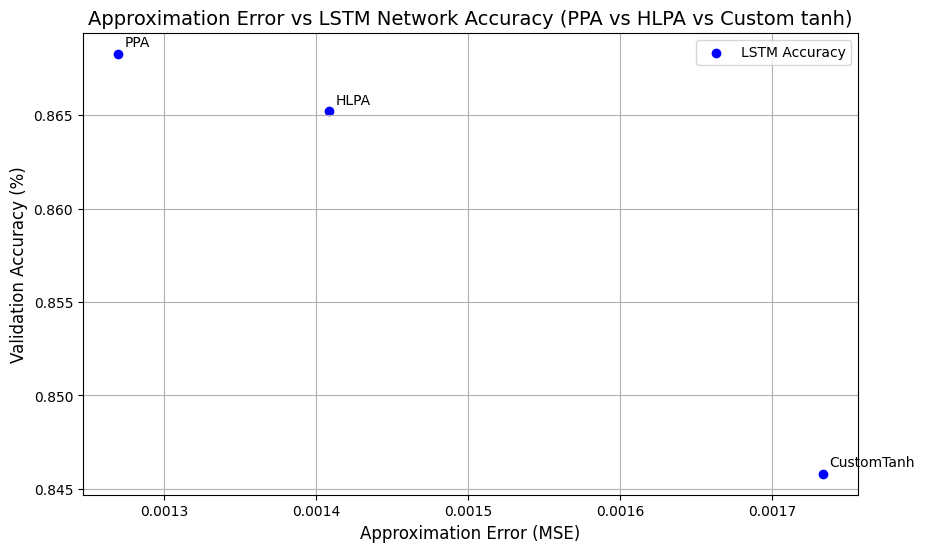

PPA - Validation Accuracy: 0.8683, Mean Approximation Error (MSE): 0.001269
HLPA - Validation Accuracy: 0.8652, Mean Approximation Error (MSE): 0.001408
CustomTanh - Validation Accuracy: 0.8458, Mean Approximation Error (MSE): 0.001733


In [ ]:
# Plot: Scatter Plot
approximation_errors = {0, 0.0025, 0.02, 0.007}
plt.figure(figsize=(10, 6))
plt.scatter(approximation_errors, validation_accuracies, color='blue', label="LSTM Accuracy")
plt.title("Approximation Error vs LSTM Network Accuracy (PPA vs HLPA vs Custom tanh)", fontsize=14)
plt.xlabel("Approximation Error (MSE)", fontsize=12)
plt.ylabel("Validation Accuracy (%)", fontsize=12)
plt.grid(True)

# Annotate each point with method name
for i, method in enumerate(activations.keys()):
    plt.annotate(method, (approximation_errors[i], validation_accuracies[i]), textcoords="offset points", xytext=(5, 5), fontsize=10)

plt.legend()
plt.show()

# Print Results
for method in activations.keys():
    print(f"{method} - Validation Accuracy: {np.max(results[method]['val_accuracy']):.4f}, "
          f"Mean Approximation Error (MSE): {mse_results[method]:.6f}")